#### Imports

In [51]:
import sys
import torch
import numpy as np
from matplotlib import pyplot as plt
from cellpose.plot import image_to_rgb
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cellpose import plot

In [2]:
sys.path.append("..")

In [ ]:
from src.model import MS2

#### Functions

In [4]:
def enhance_cell_image_contrast(image):
    if image.shape[0] < 4:
        image = np.transpose(image, (1, 2, 0))
    if image.shape[-1] < 3 or image.ndim < 3:
        image = image_to_rgb(image, channels=[0, 0])
    else:
        if image.max() <= 50.0:
            image = np.uint8(np.clip(image, 0, 1) * 255)
    return image

#### Input

In [5]:
czi_file_path = '/home/dafei/data/MS2/New-03_I.czi'
device = torch.device('cuda:0')

In [6]:
ms2 = MS2(czi_path = czi_file_path, device=device)

Successfully loaded /home/dafei/data/MS2/New-03_I.czi
data shape: (1, 64, 2, 100, 1024, 624, 1)


In [7]:
z = 0
t = 12

(np.float64(-0.5), np.float64(623.5), np.float64(1023.5), np.float64(-0.5))

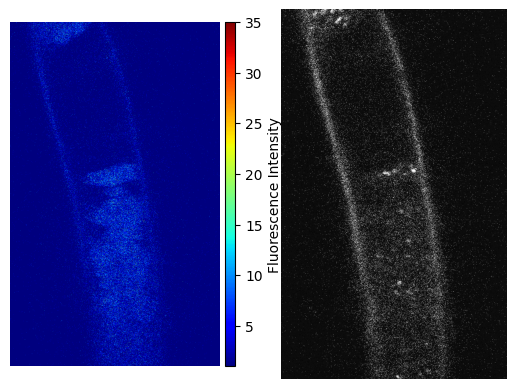

In [8]:
fluoroscent_image = ms2.get_fluorescence_image(z,t)
cells_image = ms2.image_data[0, z, ms2.microscope_channels[1], t, :, :, 0]
image = enhance_cell_image_contrast(cells_image)
fig, ax = plt.subplots(1,2)
img0 = ax[0].imshow(fluoroscent_image, cmap='jet')
# Create a divider and colorbar axis matching the height of ax[0]
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)  # Adjust size and pad as needed
cbr = fig.colorbar(img0, cax=cax, orientation='vertical')
cbr.set_label('Fluorescence Intensity')
ax[0].axis('off')
ax[1].imshow(image)
ax[1].axis('off')

In [9]:
fluoroscent_images = ms2.image_data[0, :, ms2.microscope_channels[0], :, :, :, 0]
cell_images = ms2.image_data[0, :, ms2.microscope_channels[1], :, :, :, 0]
cell_images.shape

(64, 100, 1024, 624)

In [20]:
cell_images = ms2.image_data[0, :, ms2.microscope_channels[1], :, :, :, 0]
fluoroscent_images = ms2.image_data[0, :, ms2.microscope_channels[0], :, :, :, 0]

In [22]:
z_slices,t,h,w = cell_images.shape
print(f"z_slices: {z_slices}, t: {t}, h: {h}, w: {w}")

z_slices: 64, t: 100, h: 1024, w: 624


In [41]:
cell_images[:,0,:,:].shape

(64, 1024, 624)

In [45]:
cell_z_projection_max = np.max(cell_images, axis=1)

In [46]:
cell_z_projection_mean = np.mean(cell_images, axis=1)

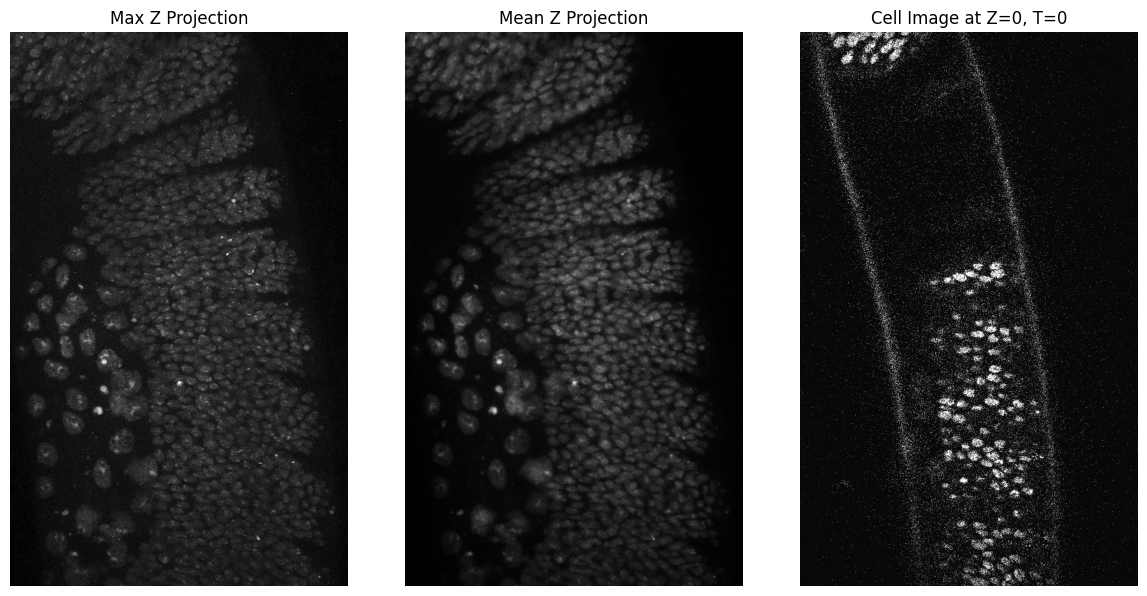

In [47]:
t = 20
z = 0
img_z0_t =  ms2.image_data[0, z, ms2.microscope_channels[1], t, :, :, 0]
img_z0_t20_enhanced = enhance_cell_image_contrast(img_z0_t)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(cell_z_projection_max[z], cmap='gray')
ax[0].set_title('Max Z Projection')
ax[0].axis('off')
ax[1].imshow(cell_z_projection_mean[z], cmap='gray')
ax[1].set_title('Mean Z Projection')
ax[1].axis('off')
ax[2].imshow(img_z0_t20_enhanced, cmap='gray')
ax[2].set_title('Cell Image at Z=0, T=0')
ax[2].axis('off')
plt.tight_layout()
plt.show()

In [48]:
mask, flows, styles = ms2.model.eval(cell_z_projection_max[z],
                                     batch_size=1,
                                     flow_threshold=ms2.flow_threshold,
                                     cellprob_threshold=ms2.cellprob_threshold,
                                     normalize={"tile_norm_blocksize": ms2.tile_norm_blocksize})

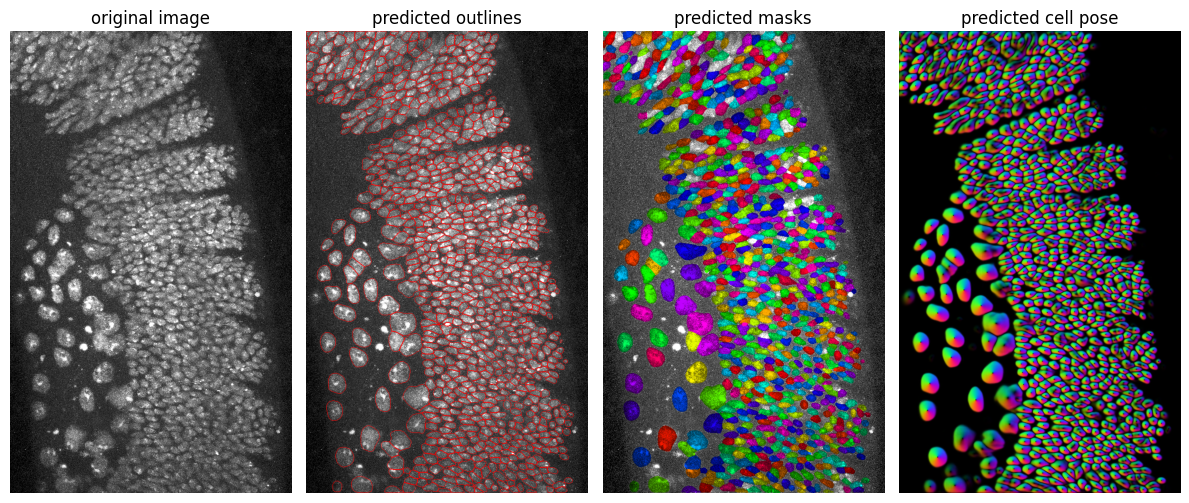

In [ ]:
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, cell_z_projection_max[z], mask, flows[0])
plt.tight_layout()
plt.show()

In [50]:
mask1, flows1, styles1 = ms2.model.eval(cell_z_projection_mean[z],
                                     batch_size=1,
                                     flow_threshold=ms2.flow_threshold,
                                     cellprob_threshold=ms2.cellprob_threshold,
                                     normalize={"tile_norm_blocksize": ms2.tile_norm_blocksize})

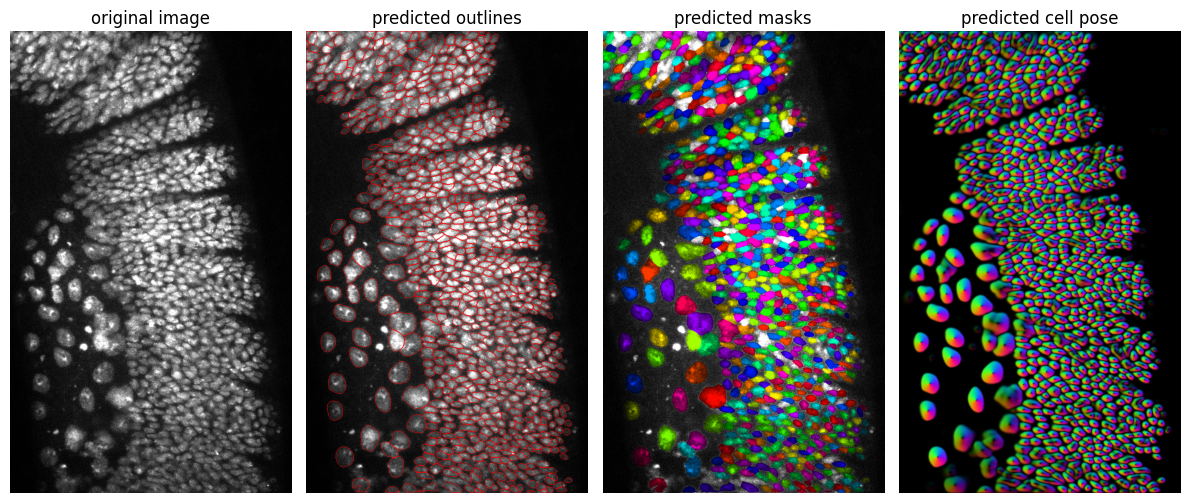

In [52]:
fig = plt.figure(figsize=(12, 5))
plot.show_segmentation(fig, cell_z_projection_mean[z], mask1, flows1[0])
plt.tight_layout()
plt.show()